# Fake News Detection - Spanish

In [1]:
# Import libraries

# Main
import sys
sys.path.insert(0,'../')
import os
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# NLP
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords
import nltk
nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords

# Transformers
from transformers import AutoTokenizer, AutoModel, TFAutoModel

# Sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Display
from IPython.display import clear_output
clear_output()

### Loading data

In [2]:
from utils import Utils
utils = Utils('/media/juan/Juan/NLP/', num_workers=10)

In [3]:
# Define language
lang = 'es'

print('Starting...')

news_data, _ = utils.data_loader(lang, 'news', total_data=7500, max_size = None, return_dates = False)
fake_news_data, _ = utils.data_loader(lang, 'FakeNews', total_data=7500, max_size = None, return_dates = False)

print(f'Loaded {len(news_data)} news {len(fake_news_data)} fake news')

data = news_data + fake_news_data
tags = [1]*len(news_data) + [0]*len(fake_news_data)

Starting...
Starting 10 threads to load 7500 documents from news in es
Loaded 7500 files in 212.73 seconds.
Removed 0 files becasuse they were too large
Starting 10 threads to load 7500 documents from FakeNews in es
Loaded 7500 files in 89.22 seconds.
Removed 0 files becasuse they were too large
Loaded 7500 news 7500 fake news


### Glimpse at data

In [4]:
news_num = 5
print(news_data[news_num])
print('-----------------------')
print(fake_news_data[news_num])

Ciudad de México, 30 abr (EFE).- El presidente de México, Andrés Manuel López Obrador, afirmó este viernes que se dará "pronto" la reapertura de la frontera terrestre entre su país y Estados Unidos, cerrada desde el comienzo de la pandemia para la mayoría de actividades.El mandatario fue preguntado en rueda d prensa sobre la reciente alerta de viajes emitida por Estados Unidos que advertía de no viajar a México por la delincuencia existente en alguna regiones y la expansión de la pandemia."Hay muy buen ambiente en las relaciones con Estados Unidos", dijo en respuesta López Obrador, quien reiteró que la próxima semana hablará con la vicepresidenta de Estados Unidos, Kamala Harris, para tratar el fenómeno migratorio.Y adelantó: "La apertura de las fronteras se va a dar pronto, completa".Dijo que del "lado estadounidense" hay también "la demanda de que se normalicen ya las relaciones y los intercambios completos"."No vemos que se prolongue mucho. Vamos a llegar pronto a un acuerdo", concl

### Basic classifiers with traditional feature extraction techniques

In [5]:
model_dict = {'NB': GaussianNB(), 
              'LR': LogisticRegression(random_state=0, max_iter = 700), 
              'MLP': MLPClassifier(hidden_layer_sizes=(500,250,100,20), random_state=1, max_iter=700),
              'SVM': svm.SVC()}
vectorizer_dict = {'tfidf': TfidfVectorizer(stop_words={'spanish'}, min_df = 30),
                   'count': CountVectorizer(stop_words={'spanish'}, min_df = 30)}

In [6]:
def create_features(vectorizer_type, data, tags):
    """ Return data and corresponding tags with data being features extracted with specified tokenizer
    
    Args:
        vectorizer_type (str): Vectorizer to use
        data (list): unprocessed corpus of data to extract features from
        tags (list): list of tags with same order as list
    
    Returns:
        np.ndarray: array with features of data
        list: tags with same order as data
    """
    vectorizer = vectorizer_dict[vectorizer_type]
    X = vectorizer.fit_transform(data).toarray()
    y = tags
    return X, y

def test_sklearn_models(model, metrics_df, X, y, vectorizer_type, val_percentage = 0.2):
    """ Train and evaluate model with specified arguments
    
    Args:
        model (str): Model to train
        metrics_df (pd.DataFrame): Dataframe to save the results
        X (np.ndarray): Features of data
        y (list): Tags of X
        vectorizer_type (str): Vectorizer used to extract features
        val_percentage (float): Validation percentage
    
    Returns:
        pd.DataFrame: Results of trained and evaluated model
    """
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=1-val_percentage)
    clf = model_dict[model]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    pre = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    data = {'model': [model], 'features': [vectorizer_type], 'lang': [lang], 'accuracy': [acc], 'precision': [pre], 'recall': [rec], 'f1': [f1]}
    df = metrics_df.append([pd.DataFrame(data=data)])
    return df

In [7]:
VECTORIZER_TYPE_ = ['tfidf', 'count']
MODEL_TPYE_ = ['NB', 'LR', 'MLP', 'SVM']
# metrics = pd.DataFrame()
metrics = pd.read_csv('./../../results/FakeNewsDetection/fake_news_detection_results.csv')
counter = 0
for vectorizer_type in VECTORIZER_TYPE_:
    X, y = create_features(vectorizer_type, data, tags)
    for model_type in MODEL_TPYE_:
        metrics = test_sklearn_models(model_type, metrics, X, y, vectorizer_type)
        print(f'Training {model_type} with {vectorizer_type} feature extraction')

Training NB with tfidf feature extraction
Training LR with tfidf feature extraction
Training MLP with tfidf feature extraction
Training SVM with tfidf feature extraction
Training NB with count feature extraction
Training LR with count feature extraction
Training MLP with count feature extraction
Training SVM with count feature extraction


In [8]:
metrics

,Unnamed: 0,model,features,lang,accuracy,precision,recall,f1
0,0.0,NB,tfidf,en,0.857333,0.858966,0.854375,0.856664
1,0.0,LR,tfidf,en,0.949333,0.968707,0.928667,0.948264
2,0.0,MLP,tfidf,en,0.954000,0.936487,0.973064,0.954425
3,0.0,SVM,tfidf,en,0.970000,0.989316,0.948770,0.968619
4,0.0,NB,count,en,0.886333,0.867997,0.908356,0.887718
5,0.0,LR,count,en,0.951333,0.964191,0.940492,0.952194
6,0.0,MLP,count,en,0.963333,0.968037,0.960518,0.964263
7,0.0,SVM,count,en,0.921333,0.996100,0.846817,0.915412
0,NaN,NB,tfidf,es,0.940333,0.907846,0.979181,0.942165
0,NaN,LR,tfidf,es,0.977667,0.984375,0.970529,0.977403


In [9]:
metrics.to_csv('./../../results/FakeNewsDetection/fake_news_detection_results.csv')

<AxesSubplot:xlabel='model'>

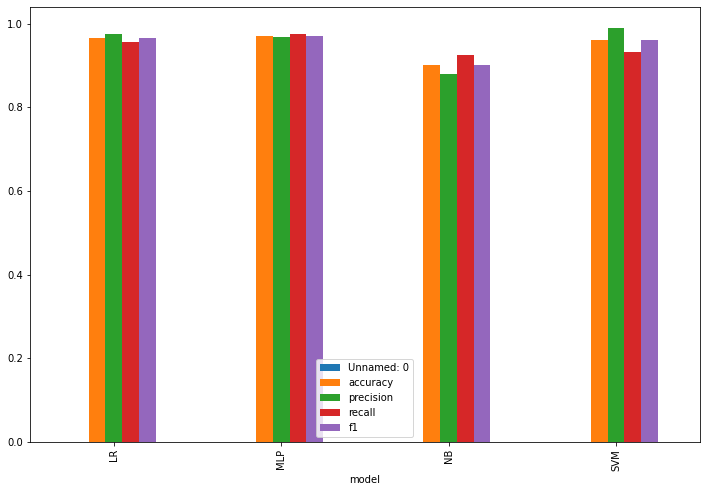

In [10]:
metrics.groupby('model').mean().plot.bar(figsize=(12,8))

<AxesSubplot:xlabel='features'>

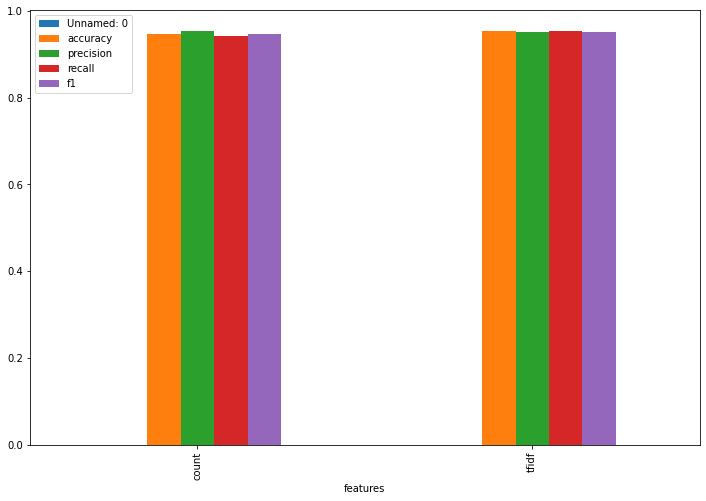

In [11]:
metrics.groupby('features').mean().plot.bar(figsize=(12,8))